In [2]:
# IMPORT STATEMENTS
import re
import numpy as np
from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')
import pandas as pd
from collections import Counter
import os
import sys
from scipy.stats import fisher_exact, ttest_ind

import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
import bone
reload(bone)
class MacAnalysis(bone.MacAnalysis):

    def __init__(self):
        bone.MacAnalysis.__init__(self)
   
    def getGSE14580(self, tn=1):
        self.prepareData("PLP53")
        atype = self.h.getSurvName('c response to infliximab')
        atypes = ['R', 'NR']
        ahash = {'Yes':0, 'No':1}
        self.initData(atype, atypes, ahash)
        
    def getARIJS_1(self, tn=1):
        self.prepareData("CD2","/home/saptarshi.sinha/Hegemon/explore.conf")
        atype = self.h.getSurvName('c response to infliximab (ch1)')
        atypes = ['Yes_Before','No_Before']
        ahash = {'CD_Yes_Before first infliximab treatment':0,'CD_No_Before first infliximab treatment':1,'UC_Yes_Before first infliximab treatment':0,'UC_No_Before first infliximab treatment':1}
        self.initData(atype, atypes, ahash)   
        
    def getVanderGoten(self, tn=1):
        self.prepareData("PLP25")
        activity = self.h.getSurvName("c disease activity")
        atype = self.h.getSurvName("c disease")
        atypes = ['Control', 'UC', 'CD', 'I', 'A', 'NA']
        ahash = {'control':0,
                'active':4, 'inactive':3, 'not applicable': 5}
        if (tn == 2):
            atypes = ['I', 'A']
            ahash = {'active':1, 'inactive':0}
            atype = activity
        self.initData(atype, atypes, ahash) 
        
    def getVanhove(self, dtype=0, tn=1):
        self.prepareData("PLP23")
        activity = self.h.getSurvName("c disease activity")
        atype = self.h.getSurvName("c disease")
        atypes = ['Control', 'UC', 'CD']
        ahash = {'ulcerative colitis':1, "Crohn's disease":2, 'control':0}
        if (tn == 2):
            atypes = ['I', 'A']
            ahash = {'active':1, 'inactive':0}
            atype = activity
        self.initData(atype, atypes, ahash)        
    
def plotViolinBar(ana, desc=None):
    fig = plt.figure(figsize=(5,5), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
#    return fig

def plotDensityBar(ana, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    ax = ana.densityPlot(ax2, acolor)
    return fig

def processData(ana, l1, wt1, desc=None, violin=1):
    ana.orderData(l1, wt1)
    if (violin == 1):
        return plotViolinBar(ana, desc)
def processDataDf(ana, l1, wt1, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)

    c_dict, fpr, tpr, roc_auc = bone.processGeneGroupsDf(ana, l1, wt1)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig

def getOrder(ana, l1):
    from scipy.stats import fisher_exact, ttest_ind
    res = []
    for s in l1:
        for gn in s:
            id1 = ana.h.getBestID(ana.h.getIDs(gn).keys())
            if id1 is None:
                continue
            e = ana.h.getExprData(id1)
            v1 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[0]])
            v2 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[1]])
            t, p = ttest_ind(v1,v2,equal_var=False)
            res += [[id1, ana.h.getSimpleName(id1),
                   t, p, np.mean(v1)-np.mean(v2)]]
    return pd.DataFrame(res, columns=['ProbeID', 'Name', 'T', 'p', 'Diff'])
def plotVolcano(ana, genes, cfile, ylim=[0, 10.5], xlim=[-6, 6]):
    df = processGenes(ana.h, [ana.state[0], ana.state[1]], genes)
    df['Size'] = 10
    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    crcdf = pd.read_csv(cfile)
    crcdf['logp'] = -np.log10(crcdf['pvalue'])
    ax = sns.scatterplot('log2FoldChange', 'logp', size=0.1, color='0.8',
                         edgecolor="none", data=crcdf)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.legend().set_visible(False)
    import io
    import base64
    buffer = io.BytesIO()
    fig.savefig(buffer, format='jpg')
    buffer.seek(0)
    volcano = base64.b64encode(buffer.read())
    from PIL import Image, ImageDraw
    buffer.seek(0)
    img = Image.open(buffer)
    x = list(ax.bbox.bounds)
    x[2] = x[2] + x[0]
    x[3] = x[3] + x[1] - 2
    x[1] = x[1] - 2
    img = img.crop(x)

    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    ax = sns.scatterplot('Diff', 'logp', hue='Diff', palette='vlag',
                         data=df, size='Size', size_norm=(0, 10), 
                         edgecolor="none", zorder=2, ax=ax)
    ax.legend().set_visible(False)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    for i in df.index:
        ax.text(df['Diff'][i]+.02, df['logp'][i], str(df['Name'][i]))
    ax.imshow(img,
              aspect = ax.get_aspect(),
              extent = ax.get_xlim() + ax.get_ylim(),
              zorder = 1) #put the map under the heatmap
    return ax

def savePList(ofile, ana, l1):
    df = getOrder(ana, l1)
    df1 = df.sort_values(by=['T'], ascending=True)
    bone.saveList(ofile, df1['Name'])


def getSource(self):
    if 'source' in self.hash:
        return self.hash['source']
    print(f"source missing in hash: {self.hash}")
    return 'unknown_source'
    

In [16]:
import bone
reload(bone)
ana = MacAnalysis()
#ana.getYang2020()#BULK
ana.getNoble2010()#SC


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

atype = ana.h.getSurvName('34SM')
ahash = {'0':0, '1':1}
df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

atype = ana.h.getSurvName('c treatment response')
ahash = {'NA':0, 'nonresponder':1, 'responder':2}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c anatomic location')
ahash = {'descending colon':0, 'ascending colon':0, 'terminal ileum':1, 'sigmoid colon':0}
df['anatomic_location'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c inflammation status')
ahash = {'inflamed':0, 'uninflamed':1, '':3}
df['inflammation_status'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c disease')
ahash = {'crohns disease':0, 'healthy':1, '':3}
df['disease'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c ethnicity')
ahash = {'CAUCASIAN':0, 'JEWISH':1, 'unknown':3}
df['ethnicity'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c joint problems')
ahash = {'FALSE':0, 'TRUE':1}
df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c family history')
ahash = {'FALSE':0, 'TRUE':1}
df['family_history'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c cdai')
ahash = {'c cdai':None, '':None}
df['cdai'] = [ahash[k] if k in ahash else k for k in atype]
df['cdai'] = np.array(df['cdai']).astype(float)


atype = ana.h.getSurvName('c harvey bradshaw')
ahash = {'c harvey bradshaw':None, '':None}
df['bradshaw'] = [ahash[k] if k in ahash else k for k in atype]
df['bradshaw'] = np.array(df['bradshaw']).astype(float)

atype = ana.h.getSurvName('c esr')
ahash = {'c esr':None, '':None}
df['esr'] = [ahash[k] if k in ahash else k for k in atype]
df['esr'] = np.array(df['esr']).astype(float)

atype = ana.h.getSurvName('c crp')
ahash = {'c crp':None, '':None}
df['crp'] = [ahash[k] if k in ahash else k for k in atype]
df['crp'] = np.array(df['crp']).astype(float)

atype = ana.h.getSurvName('c crp')
ahash = {'c crp':None, '':None}
df['crp'] = [ahash[k] if k in ahash else k for k in atype]
df['crp'] = np.array(df['crp']).astype(float)

atype = ana.h.getSurvName('c ibd affected relatives')
ahash = {'c ibd affected relatives':None, '':None}
df['affected_relatives'] = [ahash[k] if k in ahash else k for k in atype]
df['affected_relatives'] = np.array(df['affected_relatives']).astype(float)

atype = ana.h.getSurvName('c stoma ileal')
ahash = {'FALSE':0, 'TRUE':1}
df['stoma_ileal'] = [ahash[k] if k in ahash else None for k in atype]


atype = ana.h.getSurvName('c diagnosis ileal')
ahash = {'FALSE':0, 'TRUE':1}
df['diagnosis_ileal'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c diagnosis oral')
ahash = {'FALSE':0, 'TRUE':1}
df['diagnosis_oral'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c diagnosis colonic')
ahash = {'FALSE':0, 'TRUE':1}
df['diagnosis_colonic'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c diagnosis rectal')
ahash = {'FALSE':0, 'TRUE':1}
df['diagnosis_rectal'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c diagnosis anal perianal')
ahash = {'FALSE':0, 'TRUE':1}
df['diagnosis_anal_perianal'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c diagnosis vienna classifi')
ahash = {'c diagnosis vienna classifi':None, '':None}
df['c diagnosis vienna classifi'] = [ahash[k] if k in ahash else k for k in atype]
df['diagnosisVC'] = np.array(df['c diagnosis vienna classifi']).astype(float)

atype = ana.h.getSurvName('c followup vienna classific')
ahash = {'c followup vienna classific':None, '':None}
df['c followup vienna classific'] = [ahash[k] if k in ahash else k for k in atype]
df['followupVC'] = np.array(df['c followup vienna classific']).astype(float)

atype = ana.h.getSurvName('c behavior at diagnosis')
ahash = {'c behavior at diagnosis':None, '':None}
df['c behavior at diagnosis'] = [ahash[k] if k in ahash else k for k in atype]
df['behavior_at_diagnosis'] = np.array(df['c behavior at diagnosis']).astype(float)

atype = ana.h.getSurvName('c disease group')
ahash = {'FAILURE OF TREATMENT':0, 'NEW':1, 'REMISSION':2, 'sigmoid colon':3}
df['disease_group'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c disease group')
ahash = {'FAILURE OF TREATMENT':0, 'NEW':1, 'REMISSION':2, 'sigmoid colon':3}
df['anatomic_location'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c smoking status')
ahash = {'current':0, 'ex':1, 'never':2}
df['smoking_status'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c followup oral')
ahash = {'FALSE':0, 'TRUE':1}
df['followup_oral'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c followup ileal')
ahash = {'FALSE':0, 'TRUE':1}
df['followup_ileal'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c followup colonic')
ahash = {'FALSE':0, 'TRUE':1}
df['followup_colonic'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c followup rectal')
ahash = {'FALSE':0, 'TRUE':1}
df['followup_rectal'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c followup anal perianal')
ahash = {'FALSE':0, 'TRUE':1}
df['followup_anal_perianal'] = [ahash[k] if k in ahash else None for k in atype]

#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
df = df.drop(df[df.disease == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("C1 ~ anatomic_location + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
Udf1 = bone.printOLS("C1 ~ anatomic_location", df)
Udf2 = bone.printOLS("C1 ~ inflammation_status", df)
Udf3 = bone.printOLS("C1 ~ response", df)
Udf4 = bone.printOLS("C1 ~ ethnicity", df)
Udf6 = bone.printOLS("C1 ~ joint_problems", df)
Udf7 = bone.printOLS("C1 ~ family_history", df)
Udf8 = bone.printOLS("C1 ~ cdai", df)
Udf9 = bone.printOLS("C1 ~ bradshaw", df)
Udf10 = bone.printOLS("C1 ~ esr", df)
Udf11 = bone.printOLS("C1 ~ affected_relatives", df)
Udf12 = bone.printOLS("C1 ~ stoma_ileal", df)
Udf13 = bone.printOLS("C1 ~ diagnosis_oral", df)
Udf14 = bone.printOLS("C1 ~ diagnosis_ileal", df)
Udf15 = bone.printOLS("C1 ~ diagnosis_colonic", df)
Udf16 = bone.printOLS("C1 ~ diagnosis_rectal", df)
Udf17 = bone.printOLS("C1 ~ diagnosis_anal_perianal", df)
Udf18 = bone.printOLS("C1 ~ followup_ileal", df)
Udf19 = bone.printOLS("C1 ~ followup_colonic", df)
Udf20 = bone.printOLS("C1 ~ followup_rectal", df)
Udf21 = bone.printOLS("C1 ~ followup_anal_perianal", df)
Udf22 = bone.printOLS("C1 ~ delta_VC", df)
Udf23 = bone.printOLS("C1 ~ behavior_at_diagnosis", df)
Udf24 = bone.printOLS("C1 ~ disease_group", df)
Udf25 = bone.printOLS("C1 ~ smoking_status", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf6, Udf7, Udf8, Udf9, Udf10, Udf11, Udf12, Udf13, Udf14, Udf15, Udf16, Udf17, Udf18, Udf19, Udf20, Udf21, Udf22, Udf22, Udf23, Udf24, Udf25], axis=0)

Noble 2010 CD+Normal (n = 172)
GSE20881 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP58
172 17 23 27 PLP58
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.877
Date:                Thu, 13 Mar 2025   Prob (F-statistic):             0.0296
Time:                        12:52:28   Log-Likelihood:                -67.568
No. Observations:                  99   AIC:                             139.1
Df Residuals:                      97   BIC:                             144.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---

                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     7.969
Date:                Thu, 13 Mar 2025   Prob (F-statistic):            0.00577
Time:                        12:52:28   Log-Likelihood:                -66.088
No. Observations:                  99   AIC:                             136.2
Df Residuals:                      97   BIC:                             141.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5174      0

                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1077
Date:                Thu, 13 Mar 2025   Prob (F-statistic):              0.743
Time:                        12:52:28   Log-Likelihood:                -69.941
No. Observations:                  99   AIC:                             143.9
Df Residuals:                      97   BIC:                             149.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6018      0.053     11.386      0.0

In [19]:
import bone
reload(bone)
ana = MacAnalysis()
#ana.getYang2020()#BULK
ana.getGSE193677()


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

atype = ana.h.getSurvName('St')
ahash = {'0':0, '1':1}
df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

atype = ana.h.getSurvName('c demographics_gender_ch1')
ahash = {'Male':0, 'Female':1}
df['gender'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c ibd_disease_ch1')
ahash = {'Control':0, 'CD_Pouch':1,'CD':2,'UC':3,'UC_Pouch':4}
df['disease'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c ibd_endoseverity_4levels_ch1')
ahash = {'NA':0, 'Inactive':0, 'Mild':1, 'Moderate':2, 'Severe':3}
df['endoseverity'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c ibd_clinicianmeasure_inactive_active_ch1')
ahash = {'NA':0, 'Active':1, 'Inactive':3}
df['inactive_active'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c regionre_ch1')
ahash = {'Cecum':0, 'Ileum':1, 'LeftColon':0,'Rectum':0,'RightColon':0}
df['location'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c diseasetypere_ch1')
ahash = {'CD.I':1, 'CD.NonI':0, 'Control.NonI':0,'UC.I':1,'UC.NonI':0}
df['diseasetypere'] = [ahash[k] if k in ahash else None for k in atype]


df = df.drop(df[df.disease == 0].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
df1 = bone.printOLS("C1 ~ diseasetypere + location + endoseverity + inactive_active + gender", df)
#df

GSE193677 (n = 2490)
GSE193677 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=SS65.5
947 461 374 112 SS65.5
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     226.3
Date:                Thu, 13 Mar 2025   Prob (F-statistic):          3.85e-187
Time:                        12:53:02   Log-Likelihood:                -840.06
No. Observations:                1783   AIC:                             1692.
Df Residuals:                    1777   BIC:                             1725.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-

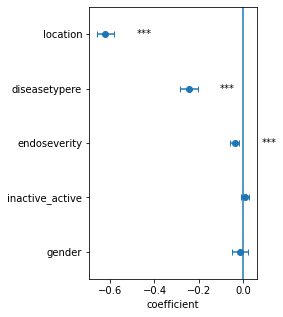

In [21]:
#import gc_mod
#reload(gc_mod)
#import Utils as ut
import bone
reload(bone)

df=df1
df = df.drop(['Intercept'])
df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
#pdf = gc_mod.getPDF("test.pdf")
#pdf.savefig(transparent=True,bbox_inches = 'tight')
#gc_mod.closePDF(pdf)
#plt.show()

In [13]:
import bone
reload(bone)
ana = MacAnalysis()
#ana.getYang2020()#BULK
ana.getSTELLARA()


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

atype = ana.h.getSurvName('St')
ahash = {'0':0, '1':1}
df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

atype = ana.h.getSurvName('c diagnosis_ch1')
ahash = {'healthy control':0, 'Crohn\'s disease':1}
df['disease'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c treatment_ch1')
ahash = {'NA':0, 'Placebo IV':1, 'Ustekinumab 130 mg IV':2, 'Ustekinumab 6 mg/kg (260 mg)':2, 'Ustekinumab 6 mg/kg (390 mg)':2,'Ustekinumab 6 mg/kg (520 mg)':2}
df['treatment'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c inflamed area at week 0_ch1')
ahash = {'Colon only':0, 'Ileum and colon':1, 'NA':3}
df['inflamed_area'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c mucosal healing at week 8_ch1')
ahash = {'NA':1, 'N':0, 'Y':1}
df['mucosal_healing'] = [ahash[k] if k in ahash else None for k in atype]


df = df.drop(df[df.disease == 0].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
df1 = bone.printOLS("C1 ~ treatment + inflamed_area + mucosal_healing", df)
#df

STELLARA (n = 148)
GSE207022 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=SS62.2
101 12 89 0 SS62.2
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5.692
Date:                Sat, 04 May 2024   Prob (F-statistic):            0.00111
Time:                        01:17:12   Log-Likelihood:                -69.025
No. Observations:                 125   AIC:                             146.0
Df Residuals:                     121   BIC:                             157.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------

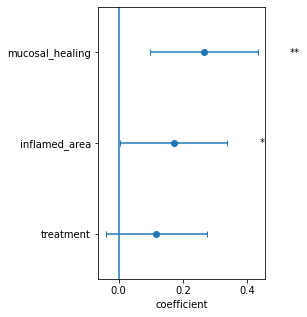

In [14]:
import gc_mod
reload(gc_mod)
import Utils as ut
import bone
reload(bone)

df=df1
df = df.drop(['Intercept'])
df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = gc_mod.getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
gc_mod.closePDF(pdf)
plt.show()

In [6]:
import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getGSE234736_vedo()


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.orderData(l1, wt1)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['C1'] = np.where(df['c1']> -8.468, 1, 0)# based on SM thesold


atype = ana.h.getSurvName('c study group (ch1)')
ahash = {'CrohnsDisease':0, 'UlcerativeColitis':1}
df['CD_UC'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c source_name (ch1)')
ahash = {'colon':0, 'ileum':1, 'jejunum':2}
df['location'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c vedolizuman response (ch1)')
ahash = {'Non-Responder':0, 'Responder':1, 'Unk':2}
df['Response'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c vedolizumab treatment (ch1)')
ahash = {'on':0, 'pre':1}
df['on_pre_treatment'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.disease == 0].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
df1 = bone.printOLS("C1 ~ CD_UC + location + Response + on_pre_treatment", df)
#df

GSE234736 (n = 96)
GSE234736 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=SS65.2
47 24 23 0 SS65.2
[34]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     6.612
Date:                Fri, 03 May 2024   Prob (F-statistic):           0.000102
Time:                        23:31:41   Log-Likelihood:                -57.409
No. Observations:                  96   AIC:                             124.8
Df Residuals:                      91   BIC:                             137.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--

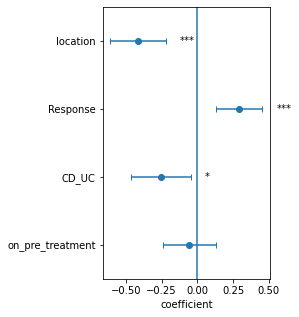

In [7]:
import gc_mod
reload(gc_mod)
import Utils as ut
import bone
reload(bone)

df=df1
df = df.drop(['Intercept'])
df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = gc_mod.getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
gc_mod.closePDF(pdf)
plt.show()


In [8]:
import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getARIJS_1()


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['C1'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold


atype = ana.h.getSurvName('c disease (ch1)')
ahash = {'Control':0,'CD':1, 'UC':2}
df['disease'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c tissue (ch1)')
ahash = {'Colon':0, 'Ileum':1}
df['location'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c response to infliximab (ch1)')
ahash = {'CD_No_After first infliximab treatment':0, 'CD_No_Before first infliximab treatment':1,'CD_Yes_After first infliximab treatment':2,'CD_Yes_Before first infliximab treatment':3,'Control_Not applicable_Not applicable':4,'UC_No_After first infliximab treatment':5,'UC_No_Before first infliximab treatment':6,'UC_Yes_After first infliximab treatment':7,'UC_Yes_Before first infliximab treatment':8}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

df = df.drop(df[df.before_after == 0].index)
df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
df1 = bone.printOLS("C1 ~ disease + location + response", df)
#df

Arijs 2009 CD2 (n = 133)
GSE16879 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=CD2
61 28 33 0 CD2
[67]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     9.606
Date:                Sun, 19 May 2024   Prob (F-statistic):           3.15e-05
Time:                        09:52:23   Log-Likelihood:                -29.891
No. Observations:                  61   AIC:                             67.78
Df Residuals:                      57   BIC:                             76.23
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

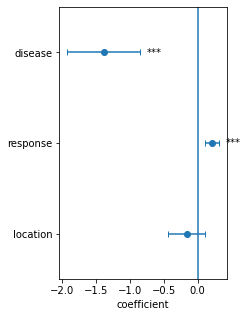

In [9]:
import gc_mod
reload(gc_mod)
import Utils as ut
import bone
reload(bone)

df=df1
df = df.drop(['Intercept'])
df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = gc_mod.getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
gc_mod.closePDF(pdf)
plt.show()


In [10]:
import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getGSE14580()


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]

ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()
ana.orderData(l1, wt1)
df['MMP'] = [None, None] + list(ana.f_ranks)
df
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]

ana.orderData(l1, wt1)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['C1'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold


atype = ana.h.getSurvName('c disease')
ahash = {'Control':0, 'UC':1}
df['disease'] = [ahash[k] if k in ahash else None for k in atype]


atype = ana.h.getSurvName('c response to infliximab')
ahash = {'Yes':0, 'No':1,'Not applicable':2}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.disease == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
df1 = bone.printOLS("C1 ~ disease+ response", df)
#df

Arijs 2009 IFX UC (n = 30)
GSE14580 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP53
24 8 16 0 PLP53
[67]
[67]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     18.50
Date:                Sat, 04 May 2024   Prob (F-statistic):           8.71e-06
Time:                        01:15:37   Log-Likelihood:                -7.0613
No. Observations:                  30   AIC:                             20.12
Df Residuals:                      27   BIC:                             24.33
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

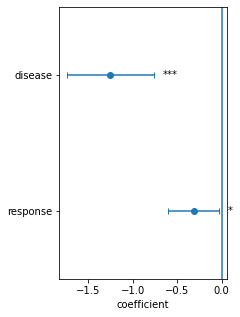

In [4]:
import gc_mod
reload(gc_mod)
import Utils as ut
import bone
reload(bone)

df=df1
df = df.drop(['Intercept'])
df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = gc_mod.getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
gc_mod.closePDF(pdf)
plt.show()


In [17]:
import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.get2023MF2()


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]

ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()
ana.orderData(l1, wt1)
df['MMP'] = [None, None] + list(ana.f_ranks)
df
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]

ana.orderData(l1, wt1)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['C1'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold


atype = ana.h.getSurvName('Treatment Type')
ahash = {'H':0, '':0, '-':0,'Naïve':1,'Naïve ':1,'Anti-TNF':2,'Anti-Integrin':3,'Mixed':4}
df['Treatment'] = [ahash[k] if k in ahash else None for k in atype]


atype = ana.h.getSurvName('CD Behavior')
ahash = {'':0, '-':0,'Stricturing':1,'Penetrating':2,'NSNP':3}
df['Behavior'] = [ahash[k] if k in ahash else None for k in atype]
                          
atype = ana.h.getSurvName('c Sample')
ahash = {'H':0, 'LONZA':0,'CD':1,'UC':1}
df['Type'] = [ahash[k] if k in ahash else None for k in atype]                          

df = df.drop(df[df.Type == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("C1 ~ Treatment + Behavior + Type", df)
#df

Udf1 = bone.printOLS("C1 ~ Treatment", df)
Udf2 = bone.printOLS("C1 ~ Behavior", df)
Udf3 = bone.printOLS("C1 ~ Type", df)


UDF=pd.concat([Udf1, Udf2, Udf3], axis=0)

MF_23 (n = 56)
PG http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=PGSS20
24 8 12 0 PGSS20
[36]
[36]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.155
Date:                Fri, 19 Apr 2024   Prob (F-statistic):              0.289
Time:                        08:24:55   Log-Likelihood:                -27.068
No. Observations:                  39   AIC:                             58.14
Df Residuals:                      37   BIC:                             61.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

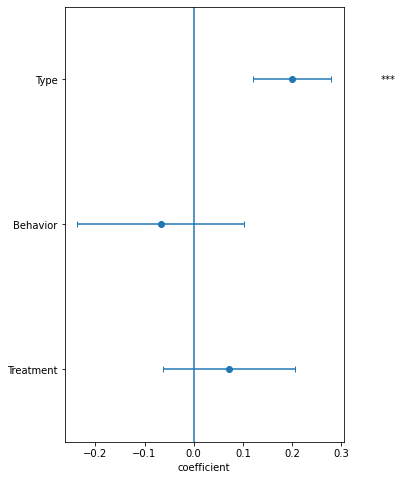

In [18]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(5,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

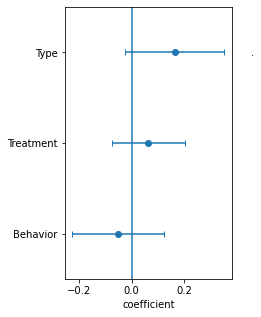

In [16]:
import gc_mod
reload(gc_mod)
import Utils as ut
import bone
reload(bone)

df=df1
df = df.drop(['Intercept'])
df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = gc_mod.getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
gc_mod.closePDF(pdf)
plt.show()


In [4]:
import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getPeters()


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]

ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()
ana.orderData(l1, wt1)
df['MMP'] = [None, None] + list(ana.f_ranks)
df
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]

ana.orderData(l1, wt1)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['C1'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold


atype = ana.h.getSurvName('c gender')
ahash = {'male':0, 'female':1}
df['Gender'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c age (yr)')
ahash = {'c age (yr)':None, '':None}
df['c age (yr)'] = [ahash[k] if k in ahash else k for k in atype]
df['Age'] = np.array(df['c age (yr)']).astype(float)

atype = ana.h.getSurvName('c clinical condition')
ahash = {'control':0, 'Crohn\'s disease':1,'Ulcerative Colitis':2}
df['Disease'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.disease == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
df1 = bone.printOLS("C1 ~ Disease + Gender + Age", df)
#df

Peters 2017 IBD (n = 134)
GSE83687 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP7
134 60 32 42 PLP7
[34]
[34]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     12.06
Date:                Wed, 08 May 2024   Prob (F-statistic):           5.16e-07
Time:                        08:23:32   Log-Likelihood:                -79.848
No. Observations:                 134   AIC:                             167.7
Df Residuals:                     130   BIC:                             179.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

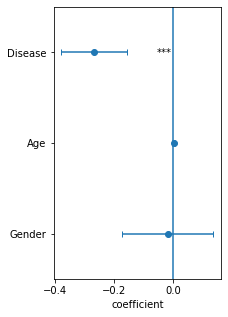

In [5]:
import gc_mod
reload(gc_mod)
import Utils as ut
import bone
reload(bone)

df=df1
df = df.drop(['Intercept'])
df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = gc_mod.getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
gc_mod.closePDF(pdf)
plt.show()


In [7]:
import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
#ana.getARIJS_1()

ana.getArijs2018(2)


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [-1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############
#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab (ch1)')
#ahash = {'CD_No_After first infliximab treatment':0, 'CD_No_Before first infliximab treatment':1,'CD_Yes_After first infliximab treatment':2,'CD_Yes_Before first infliximab treatment':3,'Control_Not applicable_Not applicable':4,'UC_No_After first infliximab treatment':5,'UC_No_Before first infliximab treatment':6,'UC_Yes_After first infliximab treatment':7,'UC_Yes_Before first infliximab treatment':8}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('Response')
ahash = {'NR':0, 'R':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C4", df)
#df





Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)

UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)

Arijs 2018 UC (n = 178)
GSE73661 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP10
82 30 52 0 PLP10
[35]
-14.471483333706795
[80]
-37.51197664500731
[1153]
-243.6362236311985
[143]
39.791324996369
[14]
-4.78312728027517
[1339]
-643.9630829721109
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8997
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.347
Time:                        15:32:39   Log-Likelihood:                -41.553
No. Observations:                  63   AIC:                             87.11
Df Residuals:                      61   BIC:                             91.39
Df Model:                           1                                         
Covariance Type:            non

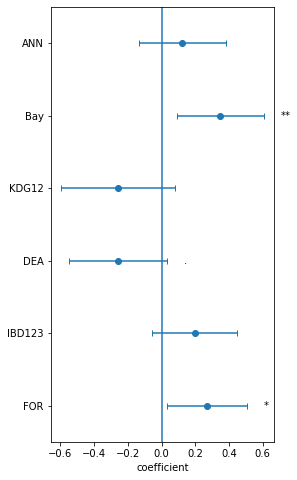

In [8]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [14]:
import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getARIJS_1()

#ana.getGSE14580()



#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############

#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c response to infliximab (ch1)')
ahash = {'CD_No_Before first infliximab treatment':0,'UC_Yes_Before first infliximab treatment':1,'UC_No_Before first infliximab treatment':0,'CD_Yes_Before first infliximab treatment':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab')
#ahash = {'Yes':0, 'No':1,'Not applicable':2}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C4", df)
#df
Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)

Arijs 2009 CD2 (n = 133)
GSE16879 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=CD2
61 28 33 0 CD2
[67]
-17.620055526896714
[218]
-48.924833705982024
[2630]
-286.31984093958
[281]
-26.780810561472148
[23]
-1.932339932189169
[2775]
-746.2390741732058
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.408
Date:                Tue, 21 May 2024   Prob (F-statistic):             0.0699
Time:                        16:29:53   Log-Likelihood:                -42.355
No. Observations:                  61   AIC:                             88.71
Df Residuals:                      59   BIC:                             92.93
Df Model:                           1                                         
Covariance Type:     

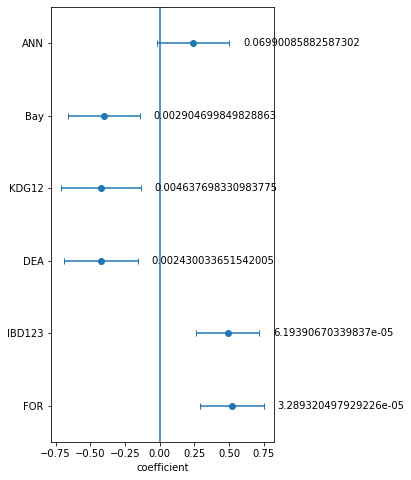

In [16]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['pvalues'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [17]:


import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getSTELLARA()

#ana.getGSE14580()



#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############

#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c mucosal healing at week 8_ch1')
ahash = {'NA':0, 'N':0, 'Y':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab')
#ahash = {'Yes':0, 'No':1,'Not applicable':2}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C1 + C2 + C3+ C4", df)
#df
Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)

STELLARA (n = 148)
GSE207022 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=SS62.2
101 12 89 0 SS62.2
[64]
-24.154785177878665
[219]
-109.20860992698307
[2474]
-873.8865227844894
[278]
-94.33835343723177
[23]
-7.847495520401163
[2683]
-1268.8698711447587
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.495
Date:                Tue, 21 May 2024   Prob (F-statistic):             0.0636
Time:                        16:32:51   Log-Likelihood:                -16.084
No. Observations:                 148   AIC:                             36.17
Df Residuals:                     146   BIC:                             42.16
Df Model:                           1                                         
Covariance Type: 

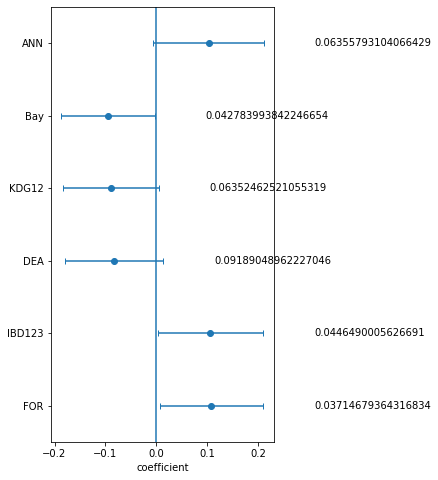

In [18]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['pvalues'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [22]:


import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getGSE23597()

#ana.getGSE14580()



#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############

#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c wk8 response (ch1)')
ahash = {'No':0, 'Yes':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab')
#ahash = {'Yes':0, 'No':1,'Not applicable':2}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C1 + C2 + C3+ C4", df)
#df
Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)


GSE23597 (n = 113)
GSE23597 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP131
81 47 34 0 PLP131
[67]
-21.32561329058702
[218]
-64.45390487745176
[2630]
-466.88241642294145
[281]
-45.705399473506105
[23]
-3.5664203941637096
[2775]
-889.6426056586657
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.2102
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.648
Time:                        16:36:23   Log-Likelihood:                -75.500
No. Observations:                 113   AIC:                             155.0
Df Residuals:                     111   BIC:                             160.5
Df Model:                           1                                         
Covariance Type:           

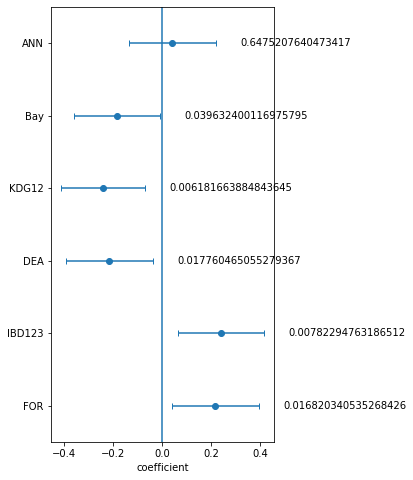

In [24]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['pvalues'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [25]:


import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getGSE14580()

#ana.getGSE14580()



#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############

#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c response to infliximab')
ahash = {'No':0, 'Yes':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab')
#ahash = {'Yes':0, 'No':1,'Not applicable':2}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C1 + C2 + C3+ C4", df)
#df
Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)


Arijs 2009 IFX UC (n = 30)
GSE14580 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP53
24 8 16 0 PLP53
[67]
-14.09318138319924
[218]
-54.58753121530027
[2630]
-261.2480335515578
[281]
-40.32272047303442
[23]
-2.812796235278186
[2775]
-648.7937396938098
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                -3.664e-15
Date:                Tue, 21 May 2024   Prob (F-statistic):               1.00
Time:                        16:47:23   Log-Likelihood:                -16.006
No. Observations:                  24   AIC:                             36.01
Df Residuals:                      22   BIC:                             38.37
Df Model:                           1                                         
Covariance Type:         

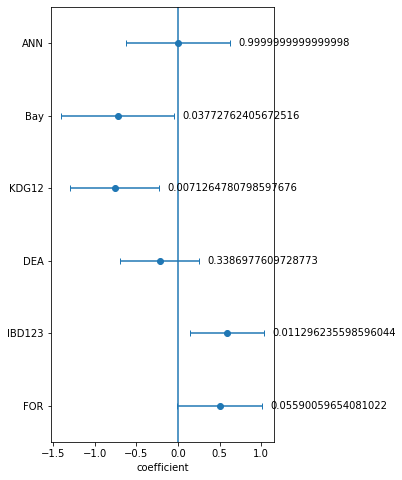

In [26]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['pvalues'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [29]:


import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getGSE12251()

#ana.getGSE14580()



#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############

#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c WK8RSPHM')
ahash = {'No':0, 'Yes':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab')
#ahash = {'Yes':0, 'No':1,'Not applicable':2}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C1 + C2 + C3+ C4", df)
#df
Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)


Arijs 2009 uc ifx (n = 23)
GSE12251 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP142
23 12 11 0 PLP142
[67]
-24.15018394830371
[218]
-65.47030402304732
[2630]
-542.3324154886591
[281]
-34.484734020338905
[23]
-4.431356202849993
[2775]
-973.9702789898006
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     2.114
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.161
Time:                        16:52:28   Log-Likelihood:                -15.569
No. Observations:                  23   AIC:                             35.14
Df Residuals:                      21   BIC:                             37.41
Df Model:                           1                                         
Covariance Type:     

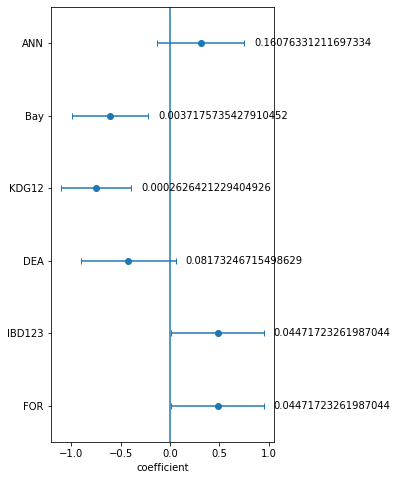

In [30]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['pvalues'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [3]:


import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getVerstockt2019()

#ana.getGSE14580()



#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############

#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c clinical history')
ahash = {'non-responder':0, 'responder':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab')
#ahash = {'Yes':0, 'No':1,'Not applicable':2}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C1 + C2 + C3+ C4", df)
#df
Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)


Verstockt 2019 IBD (n = 43)
E-MTAB-7604 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP73
43 18 25 0 PLP73
[34]
-11.68875083187543
[73]
-42.491677567795854
[1090]
-257.8645323996112
[133]
-32.25528332404471
[12]
-3.041559408821128
[1278]
-516.7062341134897
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7151
Date:                Thu, 22 Aug 2024   Prob (F-statistic):              0.403
Time:                        01:37:47   Log-Likelihood:                -30.260
No. Observations:                  43   AIC:                             64.52
Df Residuals:                      41   BIC:                             68.04
Df Model:                           1                                         
Covariance Type:    

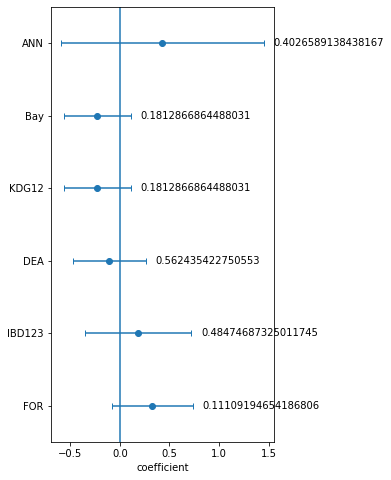

In [33]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['pvalues'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [35]:


import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getGSE234736_vedo()

#ana.getGSE14580()



#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############

#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c vedolizuman response (ch1)')
ahash = {'Non-Responder':0, 'Responder':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab')
#ahash = {'Yes':0, 'No':1,'Not applicable':2}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C1 + C2 + C3+ C4", df)
#df
Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)


GSE234736 (n = 96)
GSE234736 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=SS65.2
47 24 23 0 SS65.2
[34]
-8.468097362229887
[73]
-17.811094322836475
[1038]
-159.29155096260757
[129]
-19.416270073284753
[11]
-1.4461792560844127
[1210]
-296.45780817449486
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.264
Date:                Tue, 21 May 2024   Prob (F-statistic):             0.0242
Time:                        17:30:34   Log-Likelihood:                -62.507
No. Observations:                  90   AIC:                             129.0
Df Residuals:                      88   BIC:                             134.0
Df Model:                           1                                         
Covariance Type: 

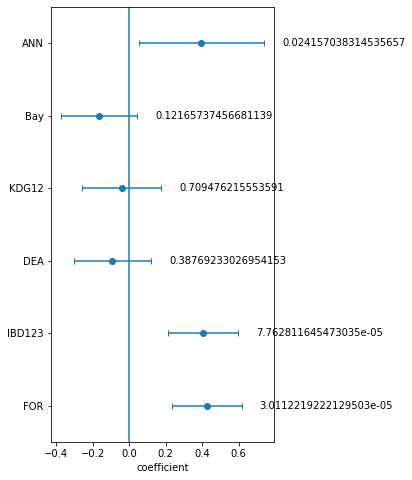

In [36]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['pvalues'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [41]:


import bone
reload(bone)
ana = MacAnalysis()
import numpy as np
#ana.getYang2020()#BULK
ana.getCorraliza2018_2()

#ana.getGSE14580()



#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('St')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [bone.getEntries('34.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)
df['c1'] = [None, None] + list(ana.f_ranks)
df['c1'] = np.array(df['c1']).astype(float)
df['FOR'] = np.where(df['c1']> fthr, 1, 0)# based on SM thesold

#########

wt1, l1 = [1], [bone.getEntries('IBD_ANN.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c2'] = [None, None] + list(ana.f_ranks)
df['c2'] = np.array(df['c2']).astype(float)
df['ANN'] = np.where(df['c2']> fthr, 1, 0)# based on SM thesold
##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_DEA.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c3'] = [None, None] + list(ana.f_ranks)
df['c3'] = np.array(df['c3']).astype(float)
df['DEA'] = np.where(df['c3']> fthr, 1, 0)# based on SM thesold

##############

#########

wt1, l1 = [1], [bone.getEntries('IBD_Bayesian.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c4'] = [None, None] + list(ana.f_ranks)
df['c4'] = np.array(df['c4']).astype(float)
df['Bay'] = np.where(df['c4']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD_KDG_12.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c5'] = [None, None] + list(ana.f_ranks)
df['c5'] = np.array(df['c5']).astype(float)
df['KDG12'] = np.where(df['c5']> fthr, 1, 0)# based on SM thesold

##############
#########

wt1, l1 = [1], [bone.getEntries('IBD123.txt', 0)]
ana.order = [i for i in ana.h.aRange()]
ana.orderData(l1, wt1)
thr = hu.getThrData(ana.f_ranks)
fthr = thr[0]
print (fthr)

df['c6'] = [None, None] + list(ana.f_ranks)
df['c6'] = np.array(df['c6']).astype(float)
df['IBD123'] = np.where(df['c6']> fthr, 1, 0)# based on SM thesold

##############

#atype = ana.h.getSurvName('c tissue (ch1)')
#ahash = {'Colon':0, 'Ileum':1}
#df['location'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c before or after first infliximab treatment (ch1)')
#ahash = {'After first infliximab treatment':0, 'Not applicable':1, 'Before first infliximab treatment':2}
#df['before_after'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c hsct responder')
ahash = {'NO':0, 'YES':1}
df['response'] = [ahash[k] if k in ahash else None for k in atype]

#atype = ana.h.getSurvName('c response to infliximab')
#ahash = {'Yes':0, 'No':1,'Not applicable':2}
#df['response'] = [ahash[k] if k in ahash else None for k in atype]

#df = df.drop(df[df.before_after == 0].index)
#df = df.drop(df[df.before_after == 1].index)
df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#atype = ana.h.getSurvName('c joint problems')
#ahash = {'FALSE':0, 'TRUE':1}
#df['joint_problems'] = [ahash[k] if k in ahash else None for k in atype]


#wt1, l1 = [1], [bone.getEntries('ipf/IPF signature_Bayesian 153 gene DOWN ONLY_PMID_21974901.txt', 0)]
#ana.orderData(l1, wt1)
#df['c1'] = [None, None] + list(ana.f_ranks)
#df['PMID_21974901dn'] = np.array(df['c1']).astype(float)





#df = df.drop(lasbels=[0,1], axis=0)

#df = df.drop(df[df['disease'] == '1'].index)
#df = df.drop(df[df.disease == 1].index)
#df = df.drop(labels=[0,1], axis=0) #to delete duplicates
#df['delta_VC']=df['followupVC'] - df['diagnosisVC']

#df1 = bone.printOLS("C1 ~ anatomic_location + inflammation_status + response + ethnicity + joint_problems + family_history + cdai + bradshaw + esr + crp + affected_relatives+ stoma_ileal + diagnosis_oral + diagnosis_ileal + diagnosis_colonic + diagnosis_rectal + diagnosis_anal_perianal + followup_oral +followup_ileal + followup_colonic + followup_rectal + followup_anal_perianal + delta_VC + behavior_at_diagnosis + disease_group + smoking_status", df)
#df1 = bone.printOLS("response ~ C1 + C2 + C3+ C4", df)
#df
Udf6 = bone.printOLS("response ~ ANN", df)
Udf5 = bone.printOLS("response ~ Bay", df)
Udf4 = bone.printOLS("response ~ KDG12", df)
Udf3 = bone.printOLS("response ~ DEA", df)
Udf2 = bone.printOLS("response ~ IBD123", df)
Udf1 = bone.printOLS("response ~ FOR", df)


UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6], axis=0)


Corraliza 2018 CD HSCT (n = 80)
GSE115390 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP71
44 28 16 0 PLP71
[34]
-5.363516826792267
[74]
-11.055421396738017
[1067]
-308.3053892261395
[132]
-21.030474722252322
[11]
-2.6094916957019705
[1258]
-472.34287658682086
                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     9.422
Date:                Tue, 21 May 2024   Prob (F-statistic):            0.00375
Time:                        17:38:14   Log-Likelihood:                -25.782
No. Observations:                  44   AIC:                             55.56
Df Residuals:                      42   BIC:                             59.13
Df Model:                           1                                         
Covariance Type

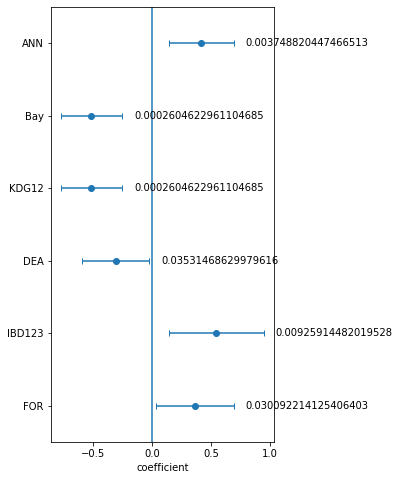

In [42]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(4,8))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['pvalues'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("test.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)